In [1]:
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


torch.set_grad_enabled(False)
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from clipppy.patches import torch_numpy

from lib.nn import FilesDataset, Head, NRE

LABELS = {
    'Om0': r'$\Omega_{m, 0}$',
    'Ode0': r'$\Omega_{\Lambda, 0}$'
}

In [2]:
from glob import glob
from pathlib import Path

N = 100
DATA_GEN = f'{N}-cosmo-ir'
EXPERIMENT_NAME = 'hpmvn'
SUFFIX = ''  # '-negrenyi'
SAVENAME = f'{EXPERIMENT_NAME}{SUFFIX}'
RESDIR = Path(f'res-{DATA_GEN}')
TRAINDIR = RESDIR / 'nntrain'

NRENAME = f'res-{DATA_GEN}/{SAVENAME}-nre.pt'
LOSSESNAME = f'res-{DATA_GEN}/{SAVENAME}-nre-losses.pt'

dataset = FilesDataset(glob(str(TRAINDIR / '*.pt')))

In [3]:
head, nre = torch.load(NRENAME)
losses = torch.load(LOSSESNAME)

In [4]:
from functools import partial
from collections import OrderedDict
from torch._vmap_internals import vmap


@partial(vmap, in_dims=(0, 0, None), out_dims=-1)
def _eval_ratio(Om0, Ode0, obs):
    return nre(*head(OrderedDict((('Om0', Om0), ('Ode0', Ode0))), obs)).squeeze(-1)


def eval_ratio(Om0, Ode0, obs):
    eval_shape = Om0.shape
    return _eval_ratio(*(
        _.unsqueeze(-1).flatten(0, len(eval_shape))
        for _ in (Om0, Ode0)
    ), obs).unflatten(-1, eval_shape)


prior_C_extent = (0.1, 0.5, 0.5, 0.9)

imkwargs = dict(origin='lower', extent=prior_C_extent)
grids = dict(zip(('Om0', 'Ode0'), (
    (x[1:] + x[:-1]) / 2
    for s in (slice(None, 2), slice(2, None))
    for x in [torch.linspace(*prior_C_extent[s], 41)]
)))
Ode0, Om0 = torch.meshgrid(grids['Ode0'], grids['Om0'])

/tmp/ipykernel_261801/1207146226.py:7: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  def _eval_ratio(Om0, Ode0, obs):


In [5]:
NTOTAL = 2048
NBATCH = 32

loader = DataLoader(dataset, batch_size=NBATCH)
head.eval(), nre.eval()

def get_quantiles(post, i):
    return [
        p[m].sum().item()
        for p, m in zip(
            post,
            (post.movedim(0, -1) > post.__getitem__((range(len(post)), *i))).movedim(-1, 0)
        )
    ]

q = []
qm = ([], [])
for i, (test_params, test_obs) in zip(tqdm(range(0, NTOTAL, NBATCH)), loader):
    posts = eval_ratio(Om0, Ode0, test_obs).exp()
    posts /= posts.sum((-2, -1), keepdims=True)
    iOde0, iOm0 = (
        torch.searchsorted(grid, test_params[key]).clip(0, len(grid)-1)
        for key in ('Ode0', 'Om0') for grid in [grids[key]]
    )
    q.extend(get_quantiles(posts, (iOde0, iOm0)))
    qm[0].extend(get_quantiles(posts.sum(-2), (iOm0,)))
    qm[1].extend(get_quantiles(posts.sum(-1), (iOde0,)))

  0%|          | 0/64 [00:00<?, ?it/s]

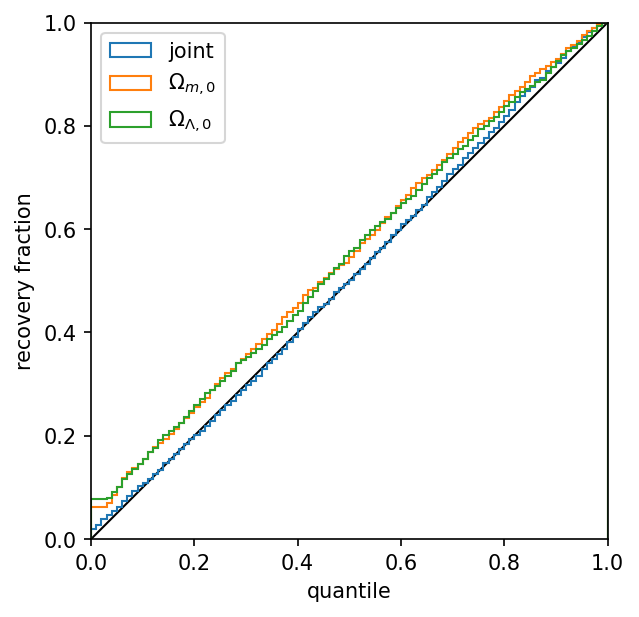

In [44]:
plt.plot(*2*((0, 1),), 'k-', lw=1, zorder=1)
for _q, lbl in zip((q, *qm), ('joint', LABELS['Om0'], LABELS['Ode0'])):
    plt.hist(_q, range=(0, 1), bins=100, cumulative=True, density=True,
             histtype='step', label=lbl, zorder=2)
plt.xlabel('quantile'); plt.ylabel('recovery fraction')
plt.xlim(0, 1); plt.ylim(0, 1)
plt.legend()
plt.gca().set_aspect('equal')
plt.savefig(RESDIR / 'plots' / 'nre-qq.png')

In [43]:
from operator import itemgetter


head.eval(), nre.eval()

for i, (_Om0, _Ode0, post) in enumerate(zip(*itemgetter('Om0', 'Ode0')(test_params), posts)):

    plt.figure()

    plt.imshow(post, **imkwargs, cmap='inferno')
    plt.plot(_Om0, _Ode0, 'gx', markeredgewidth=2, markersize=8)

    plt.xlabel(LABELS['Om0'])
    plt.ylabel(LABELS['Ode0'])

    cax = plt.colorbar()
    cax.set_label('posterior density probability')

    plt.savefig(f'res-{DATA_GEN}/plots/nre/{SAVENAME}-cosmopost-{i}.png')
    plt.close()